In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import rioxarray
import scipy.io as sio
import datetime
import pandas as pd
from scipy.signal import argrelextrema, argrelmax, argrelmin
from shapely.geometry import Polygon
import geojson
import mat73
import ir_utils

In [2]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb08_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]

In [3]:
ds_eo = ir_utils.eo_mat2dataset(files[1])

In [4]:
ds_ir = ir_utils.ir_mat2dataset(files[0])

In [5]:
ds_ir.time[0]

<xarray.DataArray 'time' ()>
array('2020-02-08T15:07:17.946189000', dtype='datetime64[ns]')
Coordinates:
    time         datetime64[ns] 2020-02-08T15:07:17.946189
    spatial_ref  int32 0

In [6]:
ds_eo.time[0]

<xarray.DataArray 'time' ()>
array('2020-02-08T15:07:22.276297000', dtype='datetime64[ns]')
Coordinates:
    time         datetime64[ns] 2020-02-08T15:07:22.276297
    spatial_ref  int32 0

---

In [7]:
def get_hist_trough(data):
    # first, find peaks
    x_peaks, y_peaks, _, _ = get_hist_peaks(data)
    
    # only look at data between the two peaks
    data = data[(data > x_peaks[0]) & (data < x_peaks[1])]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find minimum n_troughs
    if len(np.sort(n_histogram[argrelmin(n_histogram, order=1)]))>1:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])[0]
    else:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])
    # find corresponding x values to the n_troughs
    trough_x_values = x[np.where(np.isin(n_histogram,trough_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(trough_x_values, trough_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return trough_x_values, trough_y_values, x_hist, y_hist

In [8]:
def get_hist_peaks(data,n_peaks=2):
    # remove nans from data
    data = data[~np.isnan(data)]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find maximum n_peaks
    peak_y_values = np.sort(n_histogram[argrelmax(n_histogram, order=2)])[-n_peaks:][::-1]
    # find corresponding x values to the n_peaks
    peak_x_values = x[np.where(np.isin(n_histogram,peak_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(peak_x_values, peak_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return peak_x_values, peak_y_values, x_hist, y_hist

In [9]:
ds = ds_ir

In [156]:
x=500
utm_xmin, utm_xmax = 222000-x, 222000+x #221500, 222500
utm_ymin, utm_ymax = 4325300-x, 4325300+x #4325000,4325750

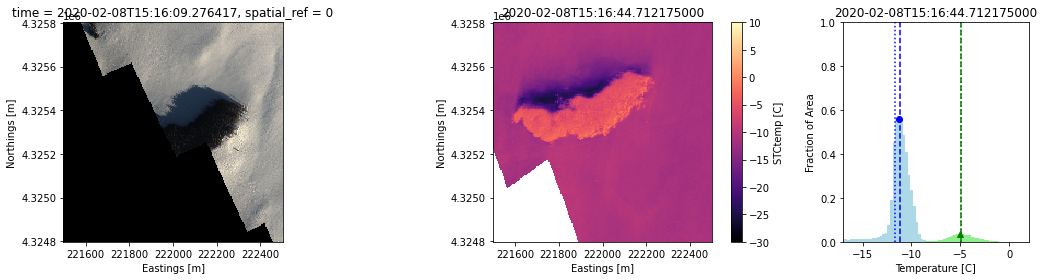

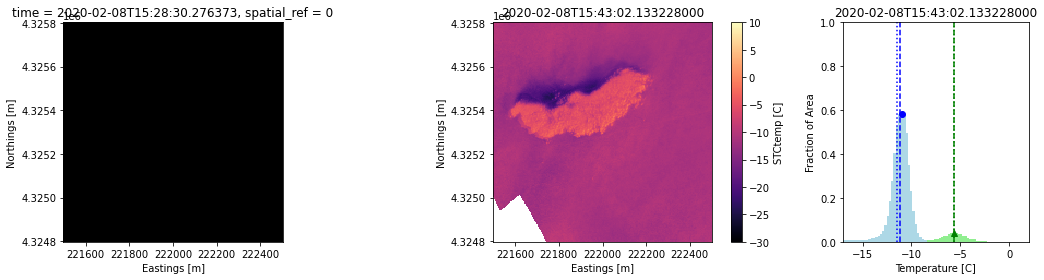

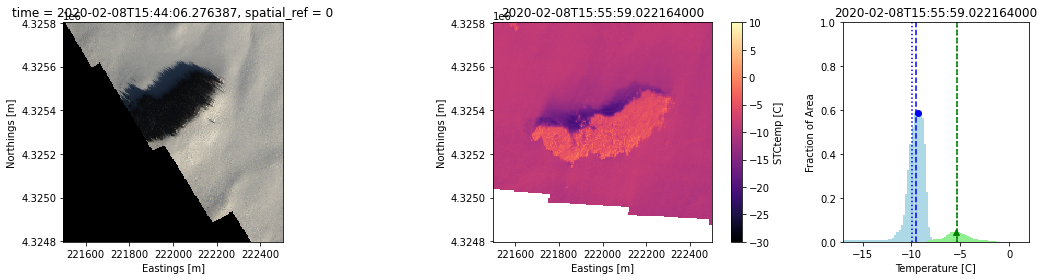

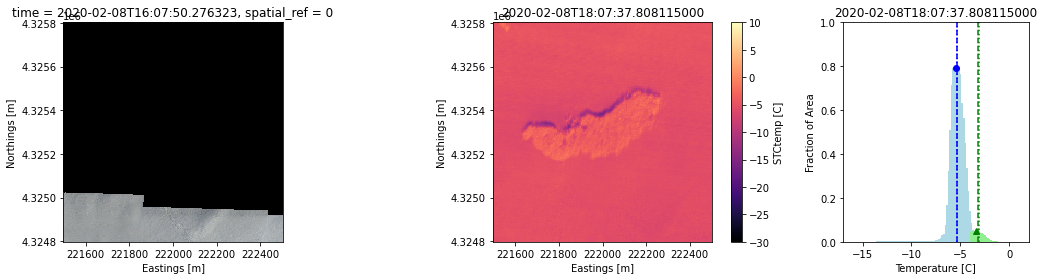

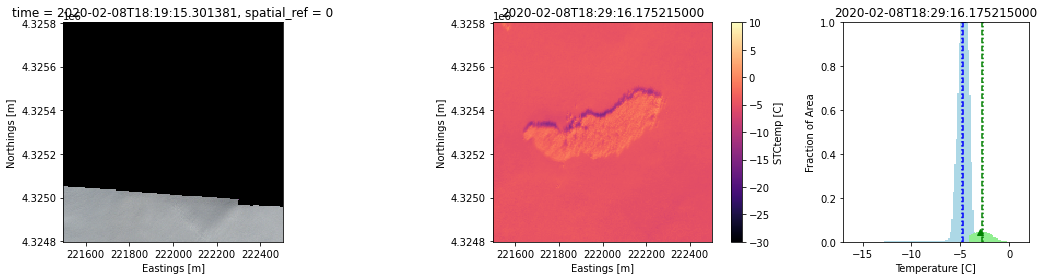

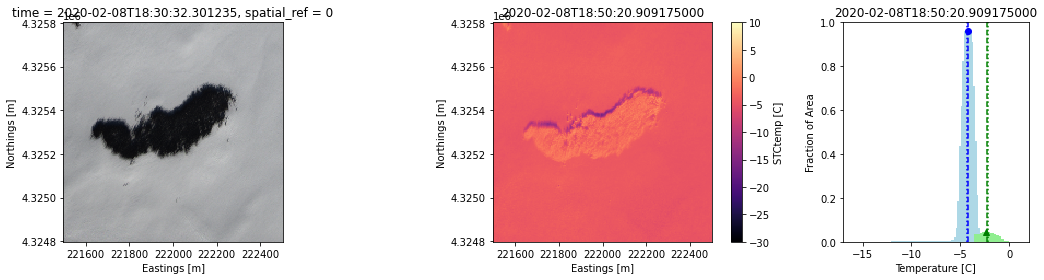

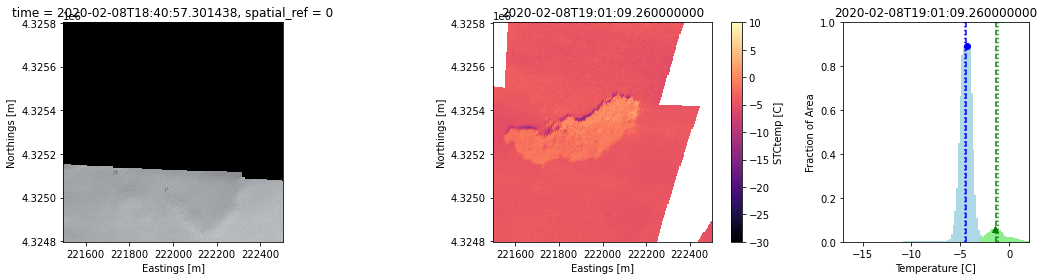

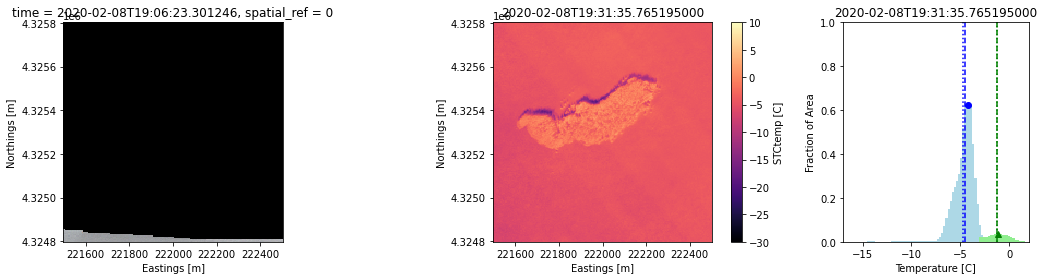

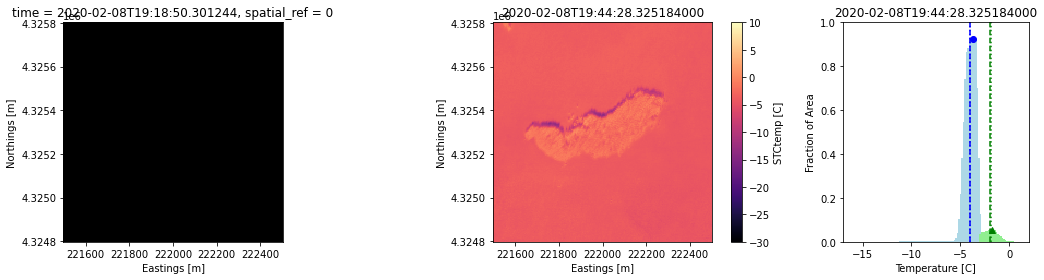

In [157]:
times = []
Tsnow_airborneIR_peak = []
Ttree_airborneIR_peak = []
Tsnow_airborneIR_median = []
Ttree_airborneIR_median = []
Tsnow_airborneIR_mean = []
Ttree_airborneIR_mean = []
Tsnow_airborneIR_min = []
Ttree_airborneIR_min = []
Tsnow_airborneIR_max = []
Ttree_airborneIR_max = []
Tsnow_airborneIR_std = []
Ttree_airborneIR_std = []

for time_index, time_step in enumerate(ds.time):
    nan_pixels = np.sum(np.isnan(ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values))
    if nan_pixels < 10000:
        fig, [ax_vis, ax_img, ax_hist] = plt.subplots(nrows=1,ncols=3,figsize=(15,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2,2, 1]})
        #
        ds_eo.SRGB.isel(time=time_index).sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax)).plot.imshow(ax=ax_vis)
        ax_vis.set_aspect('equal', 'box')
        ax_vis.set_ylabel('Northings [m]')
        ax_vis.set_xlabel('Eastings [m]')
        #
        ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
        ax_img.set_aspect('equal', 'box')
        ax_img.set_ylabel('Northings [m]')
        ax_img.set_xlabel('Eastings [m]')
        #
        data = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
        x_peaks, y_peaks, x_hist, y_hist = get_hist_peaks(data)
        x_trough, _, _, _ = get_hist_trough(data)
        x_hist_snow = x_hist[x_hist < x_trough[0]]
        y_hist_snow = y_hist[x_hist < x_trough[0]]
        x_hist_tree = x_hist[x_hist >= x_trough[0]]
        y_hist_tree = y_hist[x_hist >= x_trough[0]]
        ax_hist.bar(x_hist_snow, y_hist_snow, color='lightblue')
        ax_hist.bar(x_hist_tree, y_hist_tree, color='lightgreen')
        ax_hist.axvline(np.median(data[data < x_trough[0]]),color='b',linestyle='--')
        ax_hist.axvline(np.median(data[data >= x_trough[0]]),color='g',linestyle='--')
        ax_hist.axvline(np.mean(data[data < x_trough[0]]),color='b',linestyle=':')
        ax_hist.axvline(np.mean(data[data >= x_trough[0]]),color='g',linestyle=':')
        ax_hist.plot(x_peaks[0], y_peaks[0],'ob')
        ax_hist.plot(x_peaks[1], y_peaks[1],'^g')
        ax_hist.set_xlim(-17, 2)
        ax_hist.set_ylim(0,1)
        ax_hist.set_ylabel('Fraction of Area')
        ax_hist.set_xlabel('Temperature [C]')
        ax_img.set_title(time_step.values)
        ax_hist.set_title(time_step.values)
        # append values to lists
        times.append(time_step.values)
        Tsnow_airborneIR_peak.append(x_peaks[0])
        Ttree_airborneIR_peak.append(x_peaks[1])
        Tsnow_airborneIR_median.append(np.median(data[data < x_trough[0]]))
        Ttree_airborneIR_median.append(np.median(data[data >= x_trough[0]]))
        Tsnow_airborneIR_mean.append(np.mean(data[data < x_trough[0]]))
        Ttree_airborneIR_mean.append(np.mean(data[data >= x_trough[0]]))
        Tsnow_airborneIR_min.append(np.min(data[data < x_trough[0]]))
        Ttree_airborneIR_min.append(np.min(data[data >= x_trough[0]]))
        Tsnow_airborneIR_max.append(np.max(data[data < x_trough[0]]))
        Ttree_airborneIR_max.append(np.max(data[data >= x_trough[0]]))
        Tsnow_airborneIR_std.append(np.std(data[data < x_trough[0]]))
        Ttree_airborneIR_std.append(np.std(data[data >= x_trough[0]]))
        
times = np.array(times)
Tsnow_airborneIR_peak = np.array(Tsnow_airborneIR_peak)
Ttree_airborneIR_peak = np.array(Ttree_airborneIR_peak)
Tsnow_airborneIR_median = np.array(Tsnow_airborneIR_median)
Ttree_airborneIR_median = np.array(Ttree_airborneIR_median)
Tsnow_airborneIR_mean = np.array(Tsnow_airborneIR_mean)
Ttree_airborneIR_mean = np.array(Ttree_airborneIR_mean)
Tsnow_airborneIR_min = np.array(Tsnow_airborneIR_min)
Ttree_airborneIR_min = np.array(Ttree_airborneIR_min)
Tsnow_airborneIR_max = np.array(Tsnow_airborneIR_max)
Ttree_airborneIR_max = np.array(Ttree_airborneIR_max)
Tsnow_airborneIR_std = np.array(Tsnow_airborneIR_std)
Ttree_airborneIR_std = np.array(Ttree_airborneIR_std)

---

---

In [150]:
df = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MW-V7_clean.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_12040\3370794681.py:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MW-V7_clean.csv')


In [151]:
datestrings = [str(df['Year'][i]) + '-' + str(df['DOY'][i]) +'T' + str(df['Hour'][i]) +':' + str(df['Minute'][i]) +':00' for i in range(len(df))]
df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=5)
#
df.set_index('datetime_UTC', inplace=True)
# select Feb 8th 2020
df = df.where((df.Year==2020) & (df.Month==2) & (df.DOY==39))
df.head()

,Year,DOY,Month,Day,Hour,Minute,Decimal_Year,Flag,AirTC_10ft_Avg_C,RH_10ft_%,...,TCstringC_250cm_Avg,TCstringC_275cm_Avg,TCstringC_300cm_Avg,SM_5cm_Avg,TC_5cm_Avg_C,SM_20cm_Avg_vv,TC_20cm_Avg_C,SM_50cm_Avg_vv,TC_50cm_Avg_C,SnowDepth_m
datetime_UTC,,,,,,,,,,,,,,,,,,,,,
2016-10-10 02:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 02:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 02:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 02:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
#df = pd.read_csv('data/example_GOES_4band_tempSep_GrandMesa_Feb82020.csv')
#datestrings = [str(df['year'][i]) + '-' + str(df['doy'][i]) +'T' + str(df['hour'][i]) +':' + str(df['minute'][i]) +':00' for i in range(len(df))]
#df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=6)
#df.set_index('datetime_UTC', inplace=True)
#df.head()

---
---

In [153]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [154]:
# Set column headers:
headers_gm1 = ['table', 'year', 'doy', 'time',
               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
               'batt','b',]

# Open ground data from GM1 site:
gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
                 header = None, names = headers_gm1)

# Pad zeros to time strings
gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]

for i in range(gm1.shape[0]):
    if gm1.time_str[i] == '2400':
        gm1.time_str[i] = '0000'
        gm1.doy[i] = gm1.doy[i] + 1
        
# Convert year and day of year to pandas datetime index and convert from UTC-7 to UTC:
gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i])) + datetime.timedelta(hours=7) for i in range(gm1.shape[0])] 

# Get table 102 entires, battery info
gm1_102 = gm1[gm1.table == 102]

# Remove entries that are part of "Table 102"
gm1 = gm1[gm1.table != 102]

# Remove dates before observation periods (Feb 5th for GM1)
gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]

gm1.head()

C:\Users\steve\AppData\Local\Temp\ipykernel_12040\1590275199.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm1.time_str[i] = '0000'
C:\Users\steve\AppData\Local\Temp\ipykernel_12040\1590275199.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm1.doy[i] = gm1.doy[i] + 1
C:\Users\steve\AppData\Local\Temp\ipykernel_12040\1590275199.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]


,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt,b,time_str,date
2020-02-05 18:15:00,101,2020,36,1115,-12.522,-10.098,-19.210,2.393,-14.092,-13.954,...,-12.771,0.026,-9.1479,-9.0894,-9.2280,0.044,NaN,NaN,1115,2020-02-05
2020-02-05 18:20:00,101,2020,36,1120,-15.747,-11.359,-17.564,2.179,-14.954,-14.399,...,-12.677,0.029,-9.1214,-9.0892,-9.1404,0.019,NaN,NaN,1120,2020-02-05
2020-02-05 18:25:00,101,2020,36,1125,-17.079,-16.815,-17.328,0.167,-15.604,-15.364,...,-12.605,0.009,-9.2752,-9.1403,-9.3970,0.075,NaN,NaN,1125,2020-02-05
2020-02-05 18:30:00,101,2020,36,1130,-17.135,-16.916,-17.399,0.129,-15.769,-15.668,...,-12.815,0.062,-9.5266,-9.4124,-9.6188,0.062,NaN,NaN,1130,2020-02-05
2020-02-05 18:35:00,101,2020,36,1135,-16.898,-16.730,-17.126,0.114,-15.880,-15.859,...,-12.942,0.037,-9.6712,-9.6239,-9.7117,0.028,NaN,NaN,1135,2020-02-05


(18300.541666666668, 18301.0)

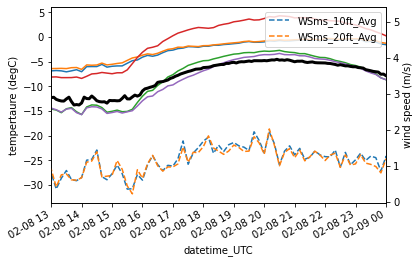

In [186]:

df.AirTC_10ft_Avg_C.plot(label='AirTC_10ft_Avg_C')
df.AirTC_20ft_Avg_C.plot(label='AirTC_20ft_Avg_C')
df.IRtarget_nadir1_C_Avg.plot(label='IRtarget_nadir1_C_Avg')
df.IRtarget_nadir2_C_Avg.plot(label='IRtarget_nadir2_C_Avg')
df.IRtarget_30degN_C_Avg.plot(label='IRtarget_30degN_C_Avg')
gm1.rad_avg.plot(linestyle='-', linewidth=3, c='k', label='2S10_IR_C', zorder=99)
#df.IRtarget_30degS_C_Avg.plot(label='IRtarget_30degS_C_Avg')
#df.TCstringC_75cm_Avg.plot(label='')
#df.TCstringC_100cm_Avg.plot(label='')

ax = plt.gca()
ax2 = ax.twinx()

df.WSms_10ft_Avg.plot(linestyle='--',ax=ax2)
df.WSms_20ft_Avg.plot(linestyle='--',ax=ax2)
ax2.set_ylabel('wind speed (m/s)')
ax.set_ylabel('tempertaure (degC)')

plt.legend()
plt.xlim(np.datetime64('2020-02-08T13'),np.datetime64('2020-02-09T00'))

---
---

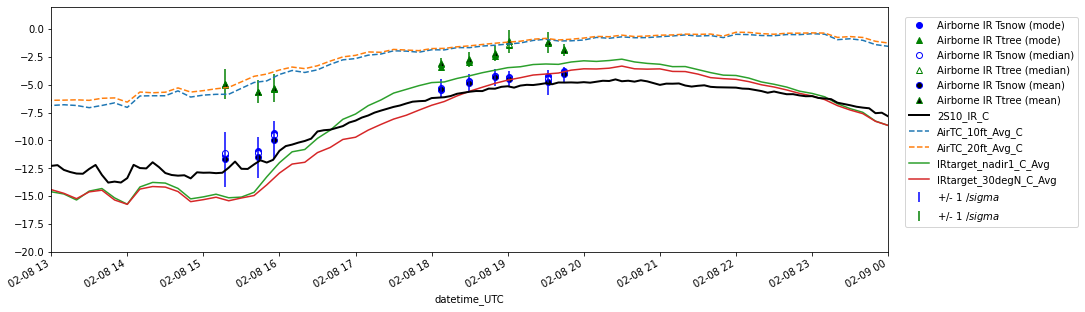

In [188]:
fig, ax =plt.subplots(1,1,figsize=(15,5))



ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(times,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(times,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
ax.plot(times,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')


ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
ax.errorbar(x=times,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')

gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)

df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
df.AirTC_20ft_Avg_C.plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--')
df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
#df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
#df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
#df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
#df.TsnowEst.plot(marker='.',ax=ax)
#df.TtreeEst.plot(marker='.',ax=ax)

ax.set_xlim(np.datetime64('2020-02-08T13'),np.datetime64('2020-02-09T00'))
ax.set_ylim(-20,2)

plt.legend(loc=(1.02,0.1))

#ax2 = ax.twinx()
#df.Solar.plot(ax=ax2)

Mean Difference between Airborne Tsnow and IRtarget_nadir1_C_Avg:
-0.9505550880432126
Mean Difference between Airborne Tveg and AirTC_10ft_Avg_C:
-0.5843410251405504
Mean Difference between Airborne Tsnow and IRtarget_30degN_C_Avg:
0.24594491195678714
Mean Difference between Airborne Tveg and AirTC_20ft_Avg_C:
-0.8540632473627726
Mean Difference between Airborne Tsnow and IRtarget_nadir1_C_Avg:
0.6577574119567872


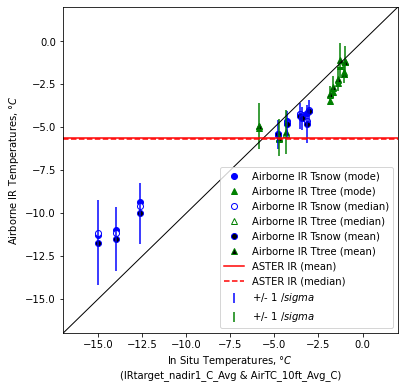

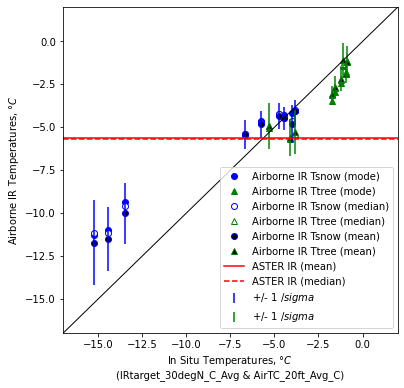

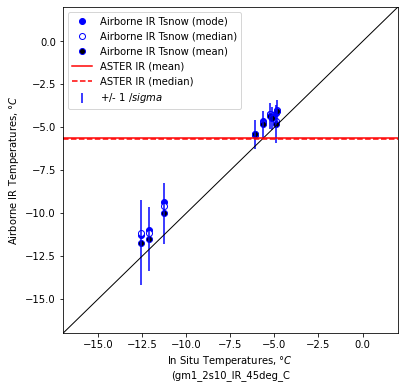

In [131]:
# Select a time window from the timeseries data around each airborne or satellite observation

plus_minus_minutes = 10 # e.g. +/- 5 minutes for a 10 minute time window

mean_AirTC_10ft_Avg_C = []
mean_AirTC_20ft_Avg_C = []
mean_IRtarget_nadir1_C_Avg = []
mean_IRtarget_30degN_C_Avg = []
gm1_2s10_IR_45deg_C = []

for i, t in enumerate(times):
    window_start_time = pd.to_datetime(t) - datetime.timedelta(minutes=plus_minus_minutes)
    window_end_time = pd.to_datetime(t) + datetime.timedelta(minutes=plus_minus_minutes)
    df_sliced = df[(df.index>window_start_time) & (df.index<window_end_time)]
    gm1_sliced = gm1[(gm1.index>window_start_time) & (gm1.index<window_end_time)]

    mean_AirTC_10ft_Avg_C.append(df_sliced.AirTC_10ft_Avg_C.mean())
    mean_AirTC_20ft_Avg_C.append(df_sliced.AirTC_20ft_Avg_C.mean())
    mean_IRtarget_nadir1_C_Avg.append(df_sliced.IRtarget_nadir1_C_Avg.mean())
    mean_IRtarget_30degN_C_Avg.append(df_sliced.IRtarget_30degN_C_Avg.mean())
    gm1_2s10_IR_45deg_C.append(gm1_sliced.rad_avg.mean())
    
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(mean_AirTC_10ft_Avg_C,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(mean_AirTC_10ft_Avg_C,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
ax.plot(mean_AirTC_10ft_Avg_C,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    
ax.errorbar(x=mean_IRtarget_nadir1_C_Avg,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
ax.errorbar(x=mean_AirTC_10ft_Avg_C,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')


ax.plot([-20,20],[-20,20],linestyle='-', linewidth=1,color='k')

ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')

ax.legend()

ax.set_ylim((-17,2))
ax.set_xlim((-17,2))

ax.set_xlabel('In Situ Temperatures, $\degree C$\n(IRtarget_nadir1_C_Avg & AirTC_10ft_Avg_C)')
ax.set_ylabel('Airborne IR Temperatures, $\degree C$')


print('Mean Difference between Airborne Tsnow and IRtarget_nadir1_C_Avg:')
print(np.mean(Tsnow_airborneIR_mean[3:] - mean_IRtarget_nadir1_C_Avg[3:]))
print('Mean Difference between Airborne Tveg and AirTC_10ft_Avg_C:')
print(np.mean(Ttree_airborneIR_median - mean_AirTC_10ft_Avg_C))

##########

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(mean_IRtarget_30degN_C_Avg,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
ax.plot(mean_IRtarget_30degN_C_Avg,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
ax.plot(mean_IRtarget_30degN_C_Avg,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    
ax.errorbar(x=mean_IRtarget_30degN_C_Avg,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
ax.errorbar(x=mean_AirTC_20ft_Avg_C,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')


ax.plot([-20,20],[-20,20],linestyle='-', linewidth=1,color='k')

ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')

ax.legend()

ax.set_ylim((-17,2))
ax.set_xlim((-17,2))

ax.set_xlabel('In Situ Temperatures, $\degree C$\n(IRtarget_30degN_C_Avg & AirTC_20ft_Avg_C)')
ax.set_ylabel('Airborne IR Temperatures, $\degree C$')

print('Mean Difference between Airborne Tsnow and IRtarget_30degN_C_Avg:')
print(np.mean(Tsnow_airborneIR_mean[3:] - mean_IRtarget_30degN_C_Avg[3:]))
print('Mean Difference between Airborne Tveg and AirTC_20ft_Avg_C:')
print(np.mean(Ttree_airborneIR_median - mean_AirTC_20ft_Avg_C))

#########

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    
    
ax.errorbar(x=gm1_2s10_IR_45deg_C,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')


ax.plot([-20,20],[-20,20],linestyle='-', linewidth=1,color='k')

ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')

ax.legend()

ax.set_ylim((-17,2))
ax.set_xlim((-17,2))

ax.set_xlabel('In Situ Temperatures, $\degree C$\n(gm1_2s10_IR_45deg_C')
ax.set_ylabel('Airborne IR Temperatures, $\degree C$')


print('Mean Difference between Airborne Tsnow and IRtarget_nadir1_C_Avg:')
print(np.mean(Tsnow_airborneIR_mean[3:] - gm1_2s10_IR_45deg_C[3:]))

Airborne IR versus in situ IR Tsnow, as a function of the in situ view angles.

(airborne IR median - in situ measurement)


In [227]:
x = np.array([(Tsnow_airborneIR_median - mean_IRtarget_nadir1_C_Avg),
    (Tsnow_airborneIR_median - mean_IRtarget_30degN_C_Avg),
    (Tsnow_airborneIR_median - gm1_2s10_IR_45deg_C)])

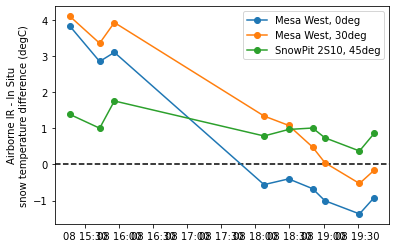

In [238]:
plt.plot(times,x.T,'o-');

plt.legend(['Mesa West, 0deg','Mesa West, 30deg','SnowPit 2S10, 45deg'])
plt.ylabel('Airborne IR - In Situ\nsnow temperature difference (degC)')
plt.axhline(0,linestyle='--', color='k', zorder=-999)


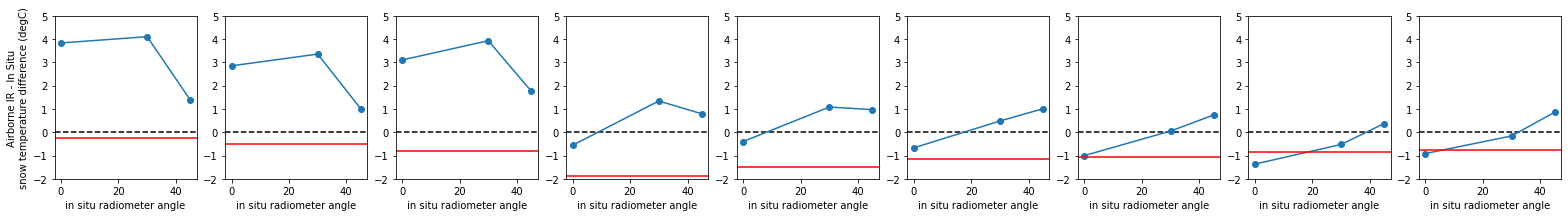

In [222]:


fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3))

for n in range(9):
    axs[n].plot([0,30,45],x[:,n],'-o');
    axs[n].axhline(x[0,n]-x[1,n],linestyle='-',color='r')
    axs[n].axhline(0,linestyle='--', color='k', zorder=-999)
    axs[0].set_ylabel('Airborne IR - In Situ\nsnow temperature difference (degC)')
    axs[n].set_xlabel('in situ radiometer angle')
    axs[n].set_ylim(-2,5)

# ---
---

# ASTER

In [80]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, mapping
import aster_utils

In [81]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

In [82]:
aster_l1t_filepath = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif"
dst_crs = 'EPSG:4326'

In [83]:
new_filepath = aster_utils.reproject_aster_l1t(aster_l1t_filepath, dst_crs = 'EPSG:32613')
print(new_filepath)

C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_EPSG_32613.tif


In [84]:
# Open ASTER image
aster_b14_DN = xr.open_dataset(new_filepath, engine="rasterio")
aster_b14_DN.rio.write_crs("epsg:32613", inplace=True)
aster_b14_DN = aster_b14_DN.squeeze()

In [85]:
#Convert DN to radiance, then radiance to brightness temperature
# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
aster_b14_rad = tir_dn2rad(aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature [K]
aster_b14_tb = tir_rad2tb(aster_b14_rad, band_number)

In [86]:
geometry = f'''{{"type": "Polygon", "coordinates": [[[{utm_xmin}, {utm_ymax}],[{utm_xmin}, {utm_ymin}],[{utm_xmax}, {utm_ymin}],[{utm_xmax}, {utm_ymax}],[{utm_xmin}, {utm_ymax}]]]}}'''
cropping_geometries = [geojson.loads(geometry)]
shapefile_tb = aster_b14_tb.rio.clip(geometries=cropping_geometries, crs=32613)
shapefile_tb_C = shapefile_tb.band_data - 273.15
#shapefile_tb_C.plot(cmap='magma')

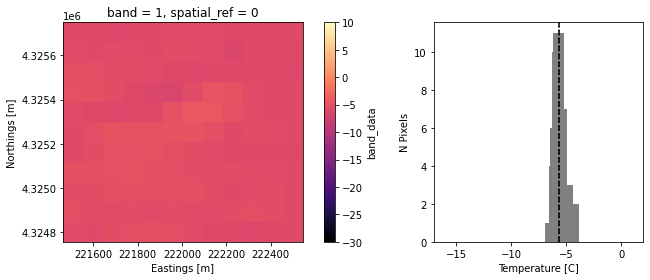

In [87]:
data = shapefile_tb_C.values

# remove nans from data
data = data[~np.isnan(data)]


fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2, 1]})
shapefile_tb_C.plot(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
ax_img.set_aspect('equal', 'box')
ax_img.set_ylabel('Northings [m]')
ax_img.set_xlabel('Eastings [m]')




y_hist, _ = np.histogram(data, bins=100, density=False)
x_hist = np.linspace(np.min(data), np.max(data), num=len(y_hist))
ax_hist.bar(x_hist, y_hist, color='grey')
ax_hist.axvline(np.median(data),color='k',linestyle='--')
ax_hist.axvline(np.mean(data),color='k',linestyle=':')
ax_hist.set_xlim(-17, 2)
#ax_hist.set_ylim(0,1)
ax_hist.set_ylabel('N Pixels')
ax_hist.set_xlabel('Temperature [C]')

aster_mesa_west_mean_TC = np.mean(data)
aster_mesa_west_median_TC = np.median(data)

---

### Add ASTER to plot

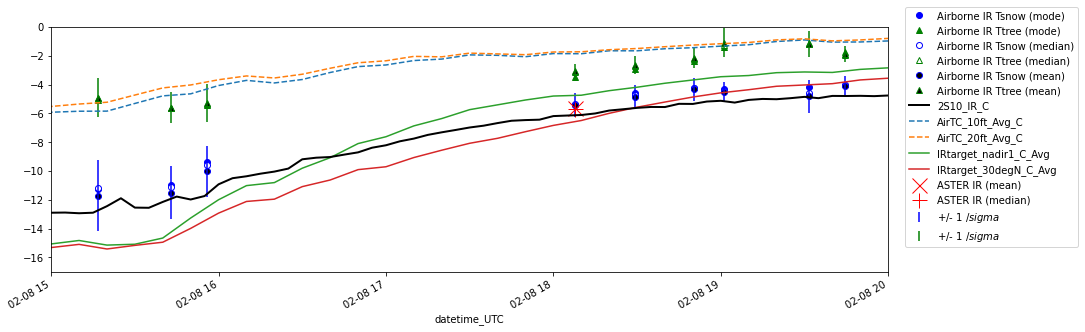

In [94]:
fig, ax =plt.subplots(1,1,figsize=(15,5))



ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(times,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(times,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
ax.plot(times,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')

ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
ax.errorbar(x=times,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')


gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)

df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
df.AirTC_20ft_Avg_C.plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--')
df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
#df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
#df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
#df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
#df.TsnowEst.plot(marker='.',ax=ax)
#df.TtreeEst.plot(marker='.',ax=ax)

aster_time = np.datetime64('2020-02-08T18:07:48')
ax.plot(aster_time,aster_mesa_west_mean_TC,'xr',markersize=15, markerfacecolor='r', label='ASTER IR (mean)')
ax.plot(aster_time,aster_mesa_west_median_TC,'+r',markersize=15, markerfacecolor='r', label='ASTER IR (median)')


ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
ax.set_ylim(-17,0)

plt.legend(loc=(1.02,0.1))

#ax2 = ax.twinx()
#df.Solar.plot(ax=ax2)